# Exercise 05 - Size optimization of trusses
We will optimize truss structures in this exercise. There is a prepared Python class for trusses called `Truss` and you can import it via `from torchfem import Truss`. The next cells show an example of how to use the truss class.

In [233]:
from math import log, sqrt

import torch
from torchfem import Truss

torch.set_default_dtype(torch.double)

The truss consists of `nodes` (tensor with shape Nx2), `elements`(list with shape Mx2), `forces` (tensor with shape Nx2) acting on nodes, constraints (boolean tensor with shape Nx2) defining for each degree of freedom wether it is constrained (`True`) or not (`False`), and cross section `areas` of each element (tensor with shape Mx1). These arguments are passed into the `Truss` class to create a new `Truss` object. We can plot the object with `Truss.plot()`.

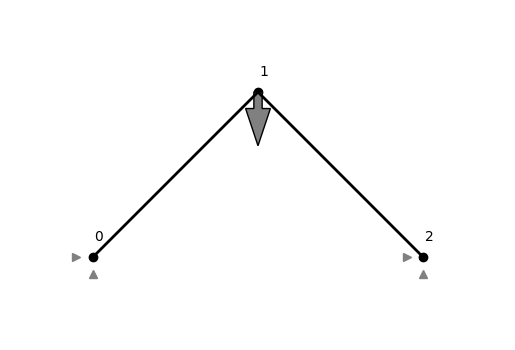

In [234]:
# Define three nodes
nodes = torch.tensor([[0.0, 0.0], [1.0, 1.0], [2.0, 0.0]])

# Define two elements connecting nodes
elements = torch.tensor([[0, 1], [1, 2]])

# Define a single force downwards in x_2 direction
forces = torch.zeros_like(nodes)
forces[1, 1] = -0.25

# Constrain all DOFs except for the central node
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, :] = True
constraints[2, :] = True

# Define initial cross sectional areas and Young's moduli
A = torch.ones((len(elements)))
E = torch.ones((len(elements)))

# Define truss
sample_truss = Truss(nodes, elements, forces, displacements, constraints, A, E)

# Plot undeformend truss
sample_truss.plot()

We can solve the truss problem for deformations at each node. This is done with a function `Truss.solve()`. The function returns displacements at each node `u`, forces at each node `f` and stresses in each bar `sigma`. 

If we pass the displacements to the `Truss.plot()` function via `(u=u)`, the visualization shows the deformed configuration. If we pass stresses via `(sigma=sigma)`, the visualization shows color-coded stress in each bar. 

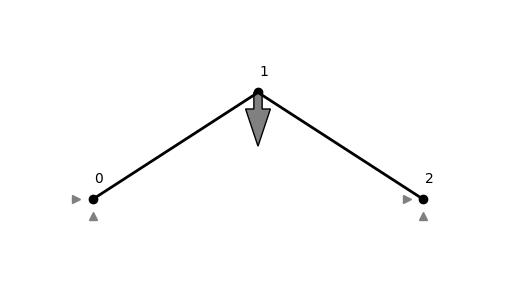

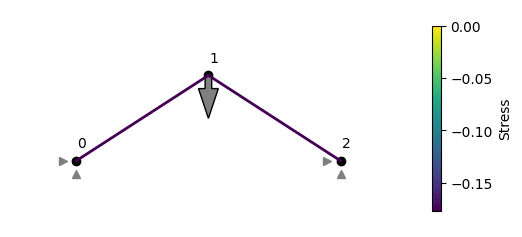

In [235]:
# Compute the solution of the truss problem
u, f = sample_truss.solve()

# Compute the stresses in each element
sigma = sample_truss.compute_stress(u)

# Plot deformend truss
sample_truss.plot(u=u)

# Plot deformend truss with stresses
sample_truss.plot(u=u, sigma=sigma)

## Task 1 - Solving a simple truss structure
Consider the three bar truss example from a previous exercise and the lecture example shown below. The coordinate origin is located at Node 1 now. 

![](../figures/three_bar_truss_bare.png)

The truss is subjected to a force $P=-0.2$ indicated by the gray arrow and supports indicated by gray triangles. It has three nodes 
$$
    \mathcal{N} = \{\mathbf{n}^0=(1,0)^\top, \mathbf{n}^1=(0,0)^\top,\mathbf{n}^2=(0,1)^\top \}
$$
and three elements 
$$
    \mathcal{E} = \{(\mathbf{n}^0, \mathbf{n}^1), (\mathbf{n}^0, \mathbf{n}^2), (\mathbf{n}^1, \mathbf{n}^2)\}.
$$



Create a truss model named `three_bar_truss` representing this truss assuming $E=10.0$ and $A=1.0$ for each element.



a) Solve the truss problem and plot the truss in its deformed configuration with colors representing stresses in bars.

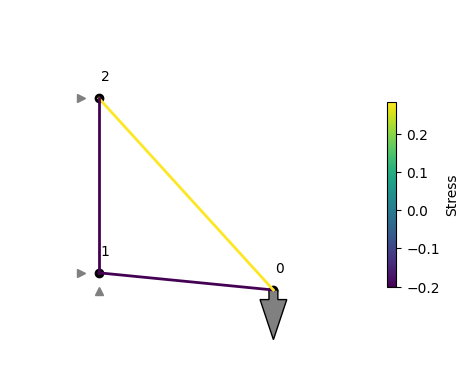

In [236]:
# Nodes
nodes = torch.tensor([[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]])
# Elements
elements = torch.tensor([[0, 1], [0, 2], [1, 2]])
# Forces
forces = torch.zeros_like(nodes)
forces[0, 1] = -0.2
# Constraints
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[1, 0] = True
constraints[1, 1] = True
constraints[2, 0] = True
# Cross section design
A = torch.ones((len(elements)))
E = 10.0 * torch.ones((len(elements)))

# Create truss
three_bar_truss = Truss(nodes, elements, forces, displacements, constraints, A, E)
# Solve truss
u, f = three_bar_truss.solve()
sigma = three_bar_truss.compute_stress(u)
# Plot truss
three_bar_truss.plot(u=u, sigma=sigma)

b) Create a function named `compute_lengths(truss)` that accepts a truss object as input and returns a tensor containing the length of each element.

In [237]:
def compute_lengths(truss):
    start_nodes = truss.nodes[truss.elements[:, 0]]
    end_nodes = truss.nodes[truss.elements[:, 1]]
    dx = end_nodes - start_nodes
    return torch.linalg.norm(dx, dim=-1)


print(compute_lengths(three_bar_truss))

tensor([1.0000, 1.4142, 1.0000])


## Task 2 - Bisection algorithm 
To solve the dual problem when optimizing the truss cross sections, we will need to find the roots $\mu^*>0$ of the gradient 
$$
\frac{\partial \underline{\mathcal{L}}}{\partial \mu}(\mu) = \mathbf{l} \cdot \mathbf{x}^* (\mu) - V_0 = 0.
$$

To prepare the search for these roots, you should implement a bisection algorithm. This algorithm performs well in this case of a highly non-linear convex optimization task, but in principle, you could also use any other gradient based algortihtm from previous exercises.

a) Write a function `bisection(f, a, b, max_iter=50, tol=1e-10)` that takes a function `f`, a bracket $[a,b]$ with $a<b$, an iteration limit `max_iter` and a tolerance for the solution `tol`. It should implement the following algorithm:
 - While $b-a > tol$: 
   - $c = \frac{a+b}{2}$
   - if $f(a)$ and $f(b)$ have the same sign, replace a with c 
   - else replace b with c 

Break the loop, if the iteration count `max_iter` is exceeeded to prevent infinite loops.

In [238]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

b) Test the function with the function $f(x)=x^3-\log(x)-5$.

In [239]:
def f(x):
    return x**3 - log(x) - 5.0


root = bisection(f, 0.1, 10.0)
print(root)

1.7729093296358767


## Task 3 - Optimization algorithm

a) Implement a truss optimization algorithm according to Example 27 in the lecture. To do so, define a function `optimize(truss, a_0, a_min, a_max, V_0)` taking a `Truss` object, an initial solution of `a`, bounds on a `a_min` and `a_max` as well as a maximum volume `V_0`.  You may re-use code from the previous MMA exercise.

In [240]:
def optimize(truss, a_0, a_min, a_max, V_0, iter=10):
    l = compute_lengths(truss)
    k0 = truss.k() / truss.areas[:, None, None]
    s = 0.7

    L = []
    a = [a_0]

    # Iterate solutions
    for k in range(iter):
        # Solve the truss problem at point a_k
        truss.areas = a[k]
        u_k, f_k = truss.solve()

        # Get strain energy of all truss elements for the given displacement
        disp = u_k[truss.elements].reshape(-1, 4)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)

        # Compute lower asymptote
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (a[k][j] - a[k - 1][j]) * (a[k - 1][j] - a[k - 2][j]) < 0.0:
                    L_k[j] = a[k][j] - s * (a[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = a[k][j] - 1 / sqrt(s) * (a[k - 1][j] - L[k - 1][j])
            L.append(L_k)
        else:
            L.append(a[k] - s * (a_max - a_min))

        # Compute lower move limit in this step
        a_min_k = torch.max(a_min, 0.9 * L[k] + 0.1 * a[k])

        # Analytical solution for a_star
        def a_star(mu):
            a_hat = L[k] + torch.sqrt((2 * w_k * (L[k] - a[k]) ** 2) / (mu * l))
            return torch.clamp(a_hat, a_min_k, a_max)

        # Analytical gradient
        def grad(mu):
            return torch.dot(a_star(mu), l) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 1e-10, 100.0)

        # Compute current optimal point with dual solution
        a.append(a_star(mu_star))

    return a

b) Test the optimization algorithm with the following code.

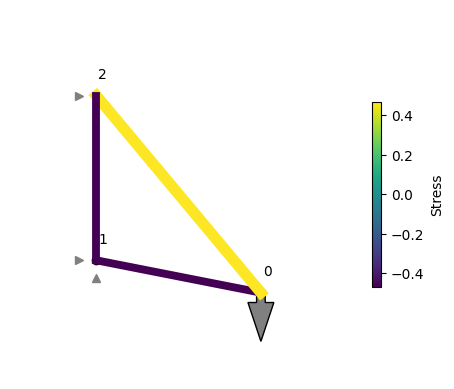

In [241]:
# Define initial solution and bounds
a_0 = torch.tensor([0.5, 0.2, 0.3])
a_min = 0.1 * torch.ones_like(a_0)
a_max = 1.0 * torch.ones_like(a_0)

# Define volume constraint
l = compute_lengths(three_bar_truss)
V0 = 0.5 * torch.dot(a_max, l)

# Optimize truss
a_opt = optimize(three_bar_truss, a_0, a_min, a_max, V0)

# Plot optimal solution
u, f = three_bar_truss.solve()
sigma = three_bar_truss.compute_stress(u)
three_bar_truss.plot(u=u, sigma=sigma, show_thickness=True)

c) Is the optimized truss a fully stressed design?

d) Compare the solution to the analytical solution from Exercise 3. Is it the same result?

## Task 4 - Your own truss

a) Create your own truss problem by defining `nodes`, `elements`, `forces` and `constraints` to your liking.

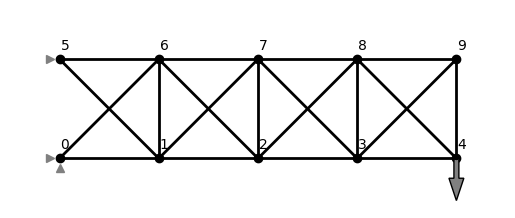

In [242]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

forces = torch.zeros_like(nodes)
forces[4, 1] = -0.1
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[5, 0] = True
areas = 10 * torch.ones((len(elements)))
moduli = torch.ones((len(elements)))

my_truss = Truss(nodes, elements, forces, displacements, constraints, areas, moduli)
my_truss.plot()

b) Solve your own truss for a prescribed distribution of cross-sectional areas. Plot the deformed truss with colored stresses. 

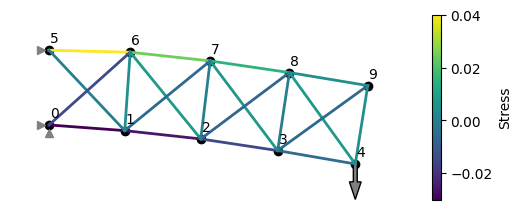

In [243]:
u, f = my_truss.solve()
sigma = my_truss.compute_stress(u)
my_truss.plot(u=u, sigma=sigma)

c) Optimize the cross sections of your own truss.

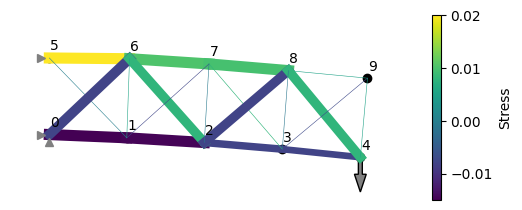

In [244]:
# Define initial solution and bounds
a_0 = 5.0 * torch.ones((len(my_truss.elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 20.0 * torch.ones_like(a_0)

# Compute volume restriction
l = compute_lengths(my_truss)
V0 = 0.5 * torch.inner(a_max, l)

# Optimize
a_opt = optimize(my_truss, a_0, a_min, a_max, V0, iter=30)

# Plot result
u, f = my_truss.solve()
sigma = my_truss.compute_stress(u)
my_truss.plot(u=u, sigma=sigma, show_thickness=True)

d) What is the interpretation of bars having the minimum cross sectional area? What would happen if we set the minimum area to zero?

> We can drop those bars from the design and we can essentially interpret this as a topology optimization. However, we cannot let them disappear completely, because that would make the stiffness matrix singular, as we cannot find a solution for the displacement of nodes connected to disappearing bars (e.g. Node 9 in this example).